***Import Modules***

In [214]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
import itertools
import os

***Load in data for various companies***

In [2]:
#Companies: AAPL, GOOG, FB, IBM, BB, MSFT, SAMSUNG
dataframes = [pd.read_csv('AAPL.csv'), pd.read_csv('GOOG.csv'), pd.read_csv('FB.csv'), pd.read_csv('IBM.csv'), pd.read_csv('BB.csv'), pd.read_csv('MSFT.csv'), pd.read_csv('SAMSUNG.csv')]
data = [df.values for df in dataframes]

***Feature engineering***

In [329]:
#REQUIREMENTS: LONG_MA_LENGTH > SHORT_MA_LENGTH (Important Note: the inequality is strict).
#              LONG_MA_LENGTH > MOMENTUM_PERIOD (Again strictly)

DAYS_AHEAD = 90
SHORT_MA_LENGTH = 30
LONG_MA_LENGTH = 90
MOMENTUM_PERIOD = 30

processed_data = np.array([]).reshape(0,8) #Second value equals number of features
for company in data:
    company_data = []
    closes = (company.T)[4]
    
    #Get Short-Term Moving Averages
    mas = []
    for i in range(DAYS_AHEAD, company.shape[0]-LONG_MA_LENGTH+1):
        ma = sum([closes[j] for j in range(i+1, i+SHORT_MA_LENGTH)])/SHORT_MA_LENGTH #average close of last SHORT_MA_LENGTH days
        mas.append(ma)
    mas = np.array(mas)
    company_data.append(mas[:-1])
    
    #Get Changes in Short-Term Moving Average
    delta_mas = []
    for i in range(company.shape[0]-LONG_MA_LENGTH-DAYS_AHEAD):
        delta_mas.append(mas[i]-mas[i+1]) #todays MA minus yesterdays MA
    delta_mas = np.array(delta_mas)
    company_data.append(delta_mas)
    
    #Get Long-Term Moving Averages
    mas = []
    for i in range(DAYS_AHEAD, company.shape[0]-LONG_MA_LENGTH+1):
        ma = sum([closes[j] for j in range(i+1, i+LONG_MA_LENGTH)])/LONG_MA_LENGTH #average close of last LONG_MA_LENGTH days
        mas.append(ma)
    mas = np.array(mas)
    company_data.append(mas[:-1])
    
    #Get Changes in Long-Term Moving Average
    delta_mas = []
    for i in range(company.shape[0]-LONG_MA_LENGTH-DAYS_AHEAD):
        delta_mas.append(mas[i]-mas[i+1]) #todays MA minus yesterdays MA
    delta_mas = np.array(delta_mas)
    company_data.append(delta_mas)
    
    #Get Momentums
    momentums = []
    for i in range(DAYS_AHEAD, company.shape[0]-LONG_MA_LENGTH):
        momentum = closes[i] - closes[i + MOMENTUM_PERIOD]
        momentums.append(momentum)
    momentums = np.array(momentums)
    company_data.append(momentums)
    
    #Get RSI
    RSIs = []
    for i in range(DAYS_AHEAD, company.shape[0]-LONG_MA_LENGTH):
        up_closes = [closes[j] for j in range(i, i+MOMENTUM_PERIOD) if closes[j] > closes[j+1]]
        down_closes = [closes[j] for j in range(i, i+MOMENTUM_PERIOD) if closes[j] < closes[j+1]]
        try:
            RS = (sum(up_closes) * len(down_closes)) / (sum(down_closes) * len(up_closes))
        except ZeroDivisionError:
            RS = 0
        RSI = 100 - 100 / (1 + RS)
        RSIs.append(RSI)
    RSIs = np.array(RSIs)
    company_data.append(RSIs)
    
    #Get Last Day Volumes (perhaps change to OBV)
    volumes = company.T[-1][DAYS_AHEAD+1:company.shape[0]-LONG_MA_LENGTH+1]
    company_data.append(volumes)
    
    #Get directions
    directions = []
    for i in range(DAYS_AHEAD, company.shape[0]-LONG_MA_LENGTH):
        diff = closes[i-DAYS_AHEAD] - closes[i]
        if diff > 0:
            directions.append('up') #increase in price
        else:
            directions.append('down') #decrease in price
    directions = np.array(directions)
    company_data.append(directions)
    
    company_data = np.array(company_data).T
    processed_data = np.vstack((processed_data, company_data))

In [330]:
data[0]

array([['2014-03-21', 75.989998, 76.25, ..., 76.12428299999999,
        67.315308, 93511600],
       ['2014-03-24', 76.91714499999999, 77.214287, ...,
        77.02714499999999, 68.113724, 88925200],
       ['2014-03-25', 77.35714, 77.964287, ..., 77.855713, 68.846397,
        70573300],
       ...,
       ['2019-03-19', 188.350006, 188.990005, ..., 186.529999,
        186.529999, 31646400],
       ['2019-03-20', 186.229996, 189.490005, ..., 188.16000400000001,
        188.16000400000001, 31035200],
       ['2019-03-21', 190.020004, 196.330002, ..., 195.08999599999999,
        195.08999599999999, 50980100]], dtype=object)

In [331]:
processed_data

array([[95.31500013333333, -0.19433340000000499, 102.52133339999996, ...,
        49.730133687102985, 56843000, 'down'],
       [95.50933353333333, -0.18433356666666612, 102.73688897777777, ...,
        49.69313006095122, 48511000, 'down'],
       [95.6936671, -0.20133336666665969, 102.91766681111108, ...,
        49.73408963387565, 39958000, 'down'],
       ...,
       [42771.666666666664, 33.33333333332848, 41953.333333333336, ...,
        50.20592295651069, 8123384, 'up'],
       [42738.333333333336, 56.66666666667152, 41967.22222222222, ...,
        50.14227712808411, 9987090, 'up'],
       [42681.666666666664, 80.0, 41974.444444444445, ...,
        50.16351786932687, 9367454, 'up']], dtype=object)

***Scaling, Oversampling and Train Test Split***

In [332]:
ys = processed_data.T[-1]
xs = processed_data.T[:-1].T

scaler = StandardScaler()
xs = scaler.fit_transform(xs)

smote = SMOTE(random_state = 1729)
xs, ys = smote.fit_resample(xs, ys)

train_xs, test_xs, train_ys, test_ys = train_test_split(xs, ys, test_size = 1/7, random_state = 1729)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


***Train Model***

In [333]:
clf = svm.SVC(C = 10, gamma = 'scale', random_state = 42, probability = True)
clf.fit(train_xs, train_ys)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

***Get Accuracy (current: accuracy = 71%, up: recall = 71%, precision = 72%, f1 = 71%, down: recall = 72%, precision = 71%, f1 = 71%)***

In [334]:
pred = clf.predict(test_xs)
total = test_ys.shape[0]
correct = len([x for x in pred==test_ys if x==True])
print('down pred:', len([i for i in pred if i == 'down']), 'up pred:', len([i for i in pred if i == 'up']))
print('down test:', len([i for i in test_ys if i == 'down']), 'up test:', len([i for i in test_ys if i == 'up']))
print("Out of a total of %d samples, %d were correct" %(total, correct))

down pred: 727 up pred: 747
down test: 733 up test: 741
Out of a total of 1474 samples, 1052 were correct


***Plot Confusion Matrix***

Normalized confusion matrix
[[0.70804911 0.29195089]
 [0.28070175 0.71929825]]


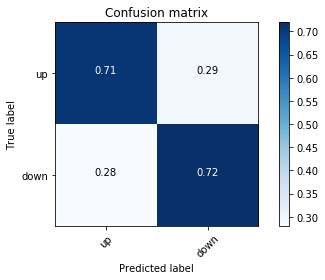

In [335]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(test_ys, pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['up', 'down'], normalize=True)

***Precision-Recall Curve***

Average precision-recall score: 0.72


Text(0.5,1,'2-class Precision-Recall curve: AP=0.72')

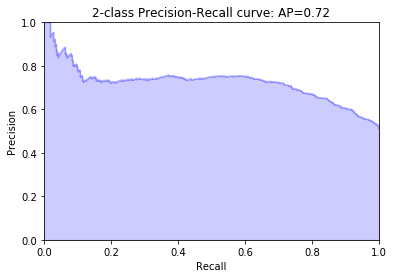

In [336]:
y_score = clf.predict_proba(test_xs).T[1]
average_precision = average_precision_score(test_ys, y_score, pos_label = 'up')
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
precision, recall, thresholds = precision_recall_curve(test_ys, y_score, pos_label = 'up')
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

***Some Basic Stuff With Predicted Probabilities***

In [337]:
#Predicted probability of upward movement, prediction and actual direction
list(zip((clf.predict_proba(test_xs)).T[1][:20], (clf.predict(test_xs))[:20], test_ys[:20])) #remove semicolon to see values


[(0.7762611609195426, 'up', 'up'),
 (0.4082336265713977, 'down', 'down'),
 (0.6779275734424685, 'up', 'up'),
 (0.8585143356255568, 'up', 'up'),
 (0.28042540013197986, 'down', 'down'),
 (0.7556461956385672, 'up', 'down'),
 (0.2545665127603067, 'down', 'down'),
 (0.6333683290984478, 'up', 'up'),
 (0.596042975038957, 'up', 'down'),
 (0.3078762722158832, 'down', 'down'),
 (0.5310790876731302, 'up', 'down'),
 (0.9152964947681436, 'up', 'up'),
 (0.5738326244605523, 'up', 'up'),
 (0.6395671027413995, 'up', 'up'),
 (0.25440835388438926, 'down', 'down'),
 (0.5149683341315154, 'up', 'up'),
 (0.6042092420024776, 'up', 'up'),
 (0.7331346928980276, 'up', 'up'),
 (0.36158694204649355, 'down', 'down'),
 (0.3283068153282917, 'down', 'down')]

In [338]:
np.mean(probabilities), np.std(probabilities)

(0.5065502862429613, 0.2132078401682585)